In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from Bio import SeqIO
from Bio.SeqIO import SeqRecord
from Bio.Seq import Seq
from matplotlib import pyplot as plt

In [2]:
def filter_annotree_df(annotree_df, min_length, max_length):
    """Remove long/short seqs and duplicates."""
    # remove short and long sequences
    mask = annotree_df.sequence.str.len() > min_length
    mask &= annotree_df.sequence.str.len() < max_length
    filtered_df = annotree_df[mask]
    
    # Keep the first of the duplicate matched because it had a lower E-val
    # (this is how annotree appears to output things)
    dup_cols = ['geneId', 'gtdbId', 'pfamId', 'sequence']
    deduplicated_df = annotree_df.drop_duplicates(subset=dup_cols, keep='first')
    return deduplicated_df

def make_fasta_from_annotree_csv(annotree_df, out_fasta_fname):
    """Convert to FASTA."""
    seqrecords = []
    # Collect records with GTDB gene ID for reference.
    for idx, row in annotree_df.iterrows():
        seqrecords.append(SeqRecord(Seq(row.sequence), id=row.geneId))
        
    # Write FASTA
    with open(out_fasta_fname, 'w') as outf:
        SeqIO.write(seqrecords, outf, 'fasta')

In [3]:
# Read both rubisco and malate synthase files
rubisco_fname = '../annotree_data/PF00016_rubisco_large_042720.csv'
rubisco_df = pd.read_csv(rubisco_fname)
rub_lens = rubisco_df.sequence.str.len()

ms_fname = '../annotree_data/PF01274_malate_synthase_042720.csv'
ms_df = pd.read_csv(ms_fname)
ms_lens = ms_df.sequence.str.len()

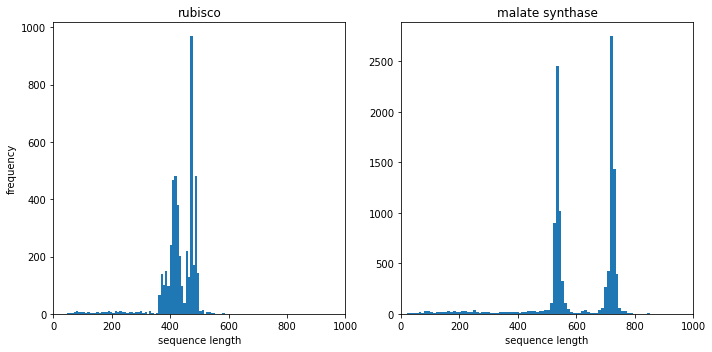

In [4]:
# Plot sequence length distributions to figure out what the right thresholds are.
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax0 = axs[0]
ax0.hist(rub_lens[rub_lens < 1000], bins=100)
ax0.set_xlim(0, 1000)
ax0.set_title('rubisco')
ax0.set_xlabel('sequence length')
ax0.set_ylabel('frequency')

ax1 = axs[1]
ax1.hist(ms_lens[ms_lens < 1000], bins=100)
ax1.set_xlim(0, 1000)
ax1.set_title('malate synthase')
ax1.set_xlabel('sequence length')

plt.tight_layout()
plt.show()

In [5]:
# Loose filters since we are just trying to get rid of absurd cases here.
rub_filtered_df = filter_annotree_df(rubisco_df, min_length=200, max_length=800)
ms_filtered_df = filter_annotree_df(ms_df, min_length=200, max_length=900)

In [6]:
print('Rubisco: pre-filtered size: %d; post: %d' % (rubisco_df.index.size, rub_filtered_df.index.size))
print('Malate Synthase: pre-filtered size: %d; post: %d' % (ms_df.index.size, ms_filtered_df.index.size))

# Should have no duplicate IDs now that we've filtered. 
# This was achieved by dropping duplicates, but the duplicates were determined by IDs and sequence
# So this check ensures all the duplicate IDs in fact had the same sequence.
assert rub_filtered_df.geneId.unique().size == rub_filtered_df.index.size
assert ms_filtered_df.geneId.unique().size == ms_filtered_df.index.size

# Save the filtered file as CSV
rub_filtered_df.to_csv('../annotree_data/PF00016_rubisco_large_042720_filtered.csv', index=False)
ms_filtered_df.to_csv('../annotree_data/PF01274_malate_synthase_042720_filtered.csv', index=False)

# Make a fasta file of the filtered rubiscos for usearch
make_fasta_from_annotree_csv(rub_filtered_df, '../annotree_data/PF00016_rubisco_large_042720_filtered.fa')

Rubisco: pre-filtered size: 4831; post: 4644
Malate Synthase: pre-filtered size: 11608; post: 11596


In [7]:
# Make a sequence database for type IV rubiscos for usearch 
jaffee_seqs = SeqIO.parse('../rubisco_sequences/jaffe_et_al_2018_rubisco_superfamilies.faa', 'fasta')
typeIVs = []
for sr in jaffee_seqs:
    rub_id = sr.id
    rub_type = rub_id.split(':')[-1]
    
    if rub_type == 'IV':
        typeIVs.append(sr)
        
with open('../rubisco_sequences/example_fIVs.fasta', 'w') as outf:
    SeqIO.write(typeIVs, outf, 'fasta')
    
!mkdir -p usearch
!usearch -makeudb_usearch ../rubisco_sequences/example_fIVs.fasta -output ../usearch/example_fIVs.udb

usearch v11.0.667_i86osx32, 4.0Gb RAM (8.6Gb total), 4 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only

00:00 1.4Mb   100.0% Reading ../rubisco_sequences/example_fIVs.fasta
00:00 1.4Mb   100.0% Masking (fastamino)                            
00:00 43Mb    100.0% Word stats         
00:00 43Mb    100.0% Alloc rows
00:00 43Mb    100.0% Build index
00:00 30Mb   Buffers (34 seqs)  
00:00 30Mb    100.0% Seqs


In [8]:
# Search against the usearch database, retaining only those sequences that are not within 30% ID of a form IV.
!usearch -usearch_global ../annotree_data/PF00016_rubisco_large_042720_filtered.fa -db ../usearch/example_fIVs.udb -id 0.35 -notmatched ../usearch/rubs_not_fIV.fa

usearch v11.0.667_i86osx32, 4.0Gb RAM (8.6Gb total), 4 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: personal use only

00:01 27Mb    100.0% Rows
00:01 27Mb   Reading pointers...done.
00:01 27Mb   Reading db seqs...done.
00:03 50Mb    100.0% Searching PF00016_rubisco_large_042720_filtered.fa, 38.5% matched


In [9]:
retained_rub_gene_ids = []
usearch_non_match_fname = '../usearch/rubs_not_fIV.fa'
for sr in SeqIO.parse(usearch_non_match_fname, 'fasta'):
    retained_rub_gene_ids.append(sr.id)
    
n_retained = len(retained_rub_gene_ids)
print('Rubisco: %d of %d did not match any fIV query' % (n_retained, rub_filtered_df.index.size))
print('These are presumed to be carboxylases')

# Retained genes are likely carboxylases
carboxylase_df = rub_filtered_df[rub_filtered_df.geneId.isin(retained_rub_gene_ids)]
carboxylase_df.to_csv('../annotree_data/PF00016_rubisco_large_042720_not_fIV.csv', index=False)

Rubisco: 2856 of 4644 did not match any fIV query
These are presumed to be carboxylases
